#### **Imports**

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm,chi2
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

colors = ['crimson','midnightblue', 'violet','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

#### **Exercise 1**

In [96]:
df_ab = pd.read_csv('ParameterEstimation_Ex1.txt',header=None)
df_ab.columns = ['Data']
data_array = df_ab['Data'].values

x_min = np.min(data_array)
x_max = np.max(data_array)

In [97]:
def likelihood(x,alpha,beta):
    pdf = 1 + alpha*x + beta*x**2    
    #integral , _ = quad(lambda x: 1 + alpha*x + beta*x**2,-0.95,0.95)
    norm = (6859 * beta + 22800) / 12000
    #norm = 2+(2*beta/3)
    return np.where(np.abs(x) <= 0.95, pdf/norm, 0.)

def likelihood(x, alpha, beta):
    # Function to integrate
    func = lambda x: 1 + alpha*x + beta*x**2
    
    norm, _ = quad(func, x_min, x_max)
    
    pdf = 1 + alpha*x + beta*x**2
    
    normalized_pdf = pdf / norm
    
    return normalized_pdf

def likelihood_changed_limits(x,alpha,beta):
    pdf = 1 + alpha*x + beta*x**2    
    norm = (6859 * beta + 22800) / 12000
    return np.where(np.logical_and(-0.9 <= x, x <= 0.85), pdf/norm, 0.)

def log_likelihood(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def neg_log_likelihood(alpha,beta,x):
    return -np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def log_likelihood_0(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=0)

def gen_MC(alpha,beta,_num_samples):
    
    #We will define a simple linear space in x and evaluate the PDF over this range.
    #xrange = np.linspace(-0.95,0.95,100)
    xrange = np.linspace(-0.9,0.85,1000)
    pdf_curve = likelihood(xrange,alpha,beta)

    #Next, we will find where the PDF evaluated on xrange has its maximum.
    #This will be our upper boundary for the accept-reject box; the lower boundary is 0.
    max_value = np.max(pdf_curve)
    min_value = 0

    #We sample uniformly from both x and the "pdf" (in reality just a variable that goes along the y-axis) to 
    #populate the accept-reject box.
    #x_samples = np.random.uniform(-0.95,0.95,_num_samples)
    x_samples = np.random.uniform(-0.9,0.85,_num_samples)
    pdf_samples = np.random.uniform(min_value,max_value,_num_samples)

    #Then, we will actually evaluate the PDFs at our x_samples given the likelihood function we defined.
    evaluated_pdfs_at_x = likelihood(x_samples,alpha,beta)
    #The accept-reject test will be passed if our "pdf samples" are below the actual PDF.
    accept_inds = np.where(evaluated_pdfs_at_x - pdf_samples > 0)[0]
    reject_inds = np.where(evaluated_pdfs_at_x - pdf_samples < 0)[0]
    
    return x_samples[accept_inds],pdf_curve

In [98]:
lambda_neg_LLH = lambda params: -log_likelihood_0(data_array,params[0],params[1])

res = minimize(lambda_neg_LLH,x0=[0.56,0.99],bounds=((0,1),(0,1)),method='L-BFGS-B')

errors = np.sqrt(np.diag(res.hess_inv.todense()))

min_a , min_b = res.x

print(f'After minimization, alpha was found to {min_a:.05} with error {errors[0]:.04}, and beta to be {min_b:.05} with error {errors[1]:.04}')

After minimization, alpha was found to 0.64679 with error 0.07949, and beta to be 0.99696 with error 0.2066


In [99]:
lambda_neg_LLH = lambda params: -log_likelihood(data_array,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res = minimize(lambda_neg_LLH,x0=[0.56,0.56],bounds=((0,1),(0,2)),method='L-BFGS-B')
errors = np.sqrt(np.diag(res.hess_inv.todense()))

min_a , min_b = res['x']

print(f'After minimization, alpha was found to {min_a:.03} with error {errors[0]:.02} and beta to be {min_b:.03} with error {errors[1]:.02}')

After minimization, alpha was found to 0.647 with error 0.21 and beta to be 0.997 with error 0.2


Text(0, 0.5, '$f(x)$')

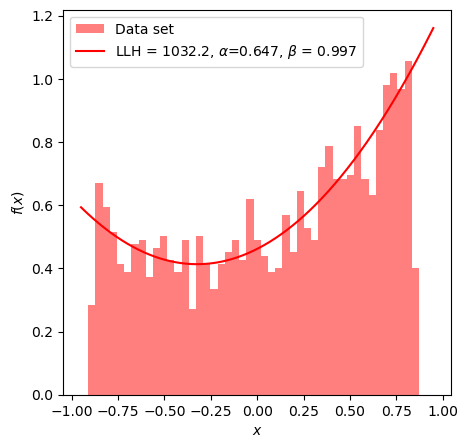

In [100]:
plt.figure(figsize = (5,5))

x_range = np.linspace(-0.95,0.95,2000)

plt.hist(data_array,bins=np.linspace(-0.95,0.95,50),density=True,alpha=0.5,label = 'Data set',color='red')
plt.plot(x_range,likelihood(x_range,alpha=min_a,beta=min_b),
         label=fr'LLH = {res.fun:.05}, $\alpha$={min_a:.03}, $\beta$ = {min_b:.03}',linestyle='-',color='red')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [101]:
N = 500 # How many pseudo-trials
MC_per_iter = 2000 # How many MC points to be generated per pseudo-trial
new_true_alpha = min_a  # True alpha value
new_true_beta = min_b   # True beta value

pseudo_alpha , pseudo_beta = [] , []

for i in range(N):
    
    generated_samples,generated_pdf = gen_MC(alpha=new_true_alpha,beta=new_true_beta,_num_samples=MC_per_iter)
    
    lambda_neg_LLH = lambda params: -log_likelihood(generated_samples,
                                np.expand_dims([params[0]],axis=0),np.expand_dims([params[1]],axis=1))

    res = minimize(lambda_neg_LLH,x0=[new_true_alpha,new_true_beta],bounds=((0,1),(0,2)),method='L-BFGS-B')
    
    errors = np.sqrt(np.diag(res.hess_inv.todense()))

    min_a , min_b = res.x

    pseudo_alpha.append(min_a)
    pseudo_beta.append(min_b)

**Fixing alpha**

In [102]:
def likelihood_fixed_alpha(x,beta):
    # Function to integrate
    func = lambda x: 1 + 0.65*x + beta*x**2
    
    norm, _ = quad(func, x_min, x_max)
    
    pdf = 1 + 0.65*x + beta*x**2
    
    normalized_pdf = pdf / norm
    
    return normalized_pdf

# Adjusted log likelihood function for a fixed alpha
def log_likelihood_fixed_alpha(x, beta):
    return np.sum(np.log(likelihood_fixed_alpha(x, beta)))

fixed_pseudo_beta = []

# N = 1000

for i in range(N):
    
    generated_samples,generated_pdf = gen_MC(alpha=0.65,beta=new_true_beta,_num_samples=MC_per_iter)

    # Adjusted negative log likelihood function for optimization
    lambda_neg_LLH_fixed_alpha = lambda beta: -log_likelihood_fixed_alpha(generated_samples, beta)

    # Optimization for beta only, with alpha fixed at 0.65
    res_fixed_alpha = minimize(lambda_neg_LLH_fixed_alpha, x0=[0.5], bounds=[(0.,2)], method='L-BFGS-B')
    errors_fixed_alpha = np.sqrt(np.diag(res_fixed_alpha.hess_inv.todense()))

    fixed_pseudo_beta.append(res_fixed_alpha.x[0])

**Exercise 1b**

In [103]:
alpha_low, alpha_high = np.percentile(pseudo_alpha, [15.865, 84.135])
beta_low, beta_high = np.percentile(pseudo_beta, [15.865, 84.135])
fixed_beta_low, fixed_beta_high = np.percentile(fixed_pseudo_beta, [15.865, 84.135])

In [104]:
print(f'For alpha fits, the one-sigma interval is {alpha_high - alpha_low:.03}')
print(f'For beta fits, the one-sigma interval is {beta_high - beta_low:.03}')
print(f'For beta fitting with alpha fixed, the one-sigma interval is {fixed_beta_high - fixed_beta_low:.03}')

For alpha fits, the one-sigma interval is 0.177
For beta fits, the one-sigma interval is 0.415
For beta fitting with alpha fixed, the one-sigma interval is 0.338


**Plotting**

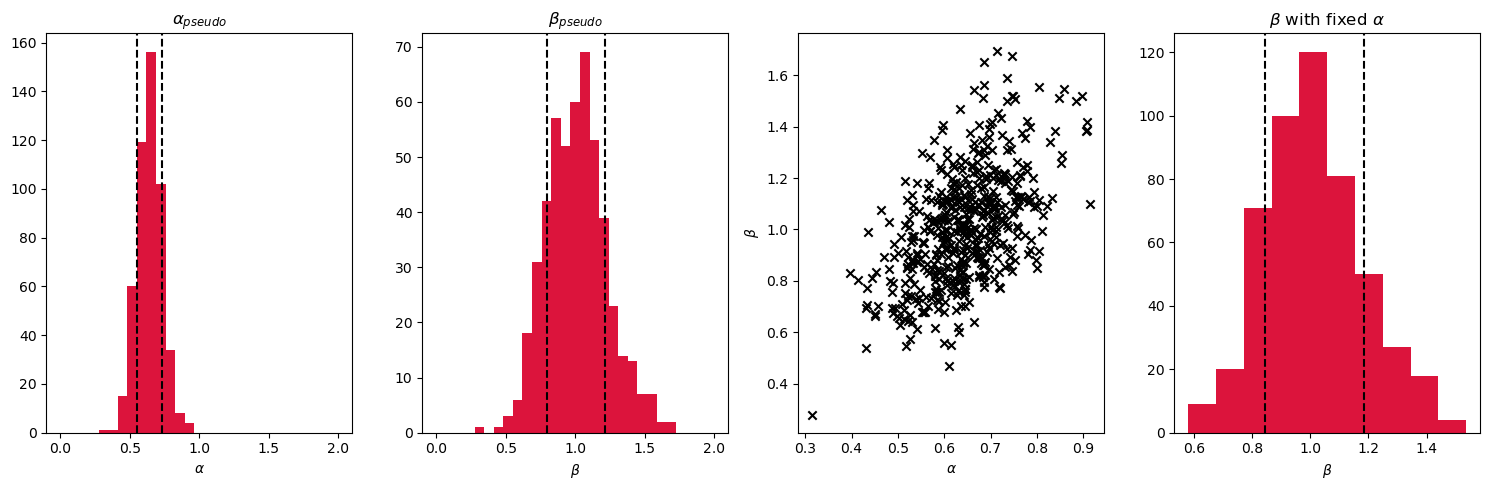

In [105]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax[0].hist(pseudo_alpha,bins=np.linspace(0.,2.,30),density=False,label = r'${\alpha}_{pseudo}$')
ax[0].set_title(r'${\alpha}_{pseudo}$')
ax[0].set_xlabel(r'$\alpha$')  # Set x-axis label
ax[0].axvline(x=alpha_low, color='k', linestyle='--')
ax[0].axvline(x=alpha_high, color='k', linestyle='--')

ax[1].hist(pseudo_beta,bins=np.linspace(0.,2.,30),density=False,label = r'${\beta}_{pseudo}$')
ax[1].set_title(r'${\beta}_{pseudo}$')
ax[1].set_xlabel(r'$\beta$')  # Set x-axis label
ax[1].axvline(x=beta_low, color='k', linestyle='--')
ax[1].axvline(x=beta_high, color='k', linestyle='--')

ax[2].scatter(pseudo_alpha,pseudo_beta,marker='x',color='black')
ax[2].set_xlabel(r'$\alpha$')  # Set x-axis label
ax[2].set_ylabel(r'$\beta$')  # Set x-axis label

ax[3].hist(fixed_pseudo_beta,density=False,label = r'${\beta}_{pseudo}$')
ax[3].set_xlabel(r'$\beta$')  # Set x-axis label
ax[3].set_title(r'$\beta$ with fixed $\alpha$')
ax[3].axvline(x=fixed_beta_high, color='k', linestyle='--')
ax[3].axvline(x=fixed_beta_low, color='k', linestyle='--')

plt.tight_layout()
plt.show()

**Exercise 1c**

In [106]:
def likelihood_fix(x,beta):
    # Function to integrate
    func = lambda x: 1 + 0.65*x + beta*x**2
    
    norm, _ = quad(func, -0.9, 0.85)
    
    pdf = 1 + 0.65*x + beta*x**2
    
    normalized_pdf = pdf / norm
    
    return normalized_pdf

def log_likelihood_fix(x,beta):
    return np.sum(np.log(likelihood_fix(x,beta)))

# Find beta that maximizes the log likelihood (i.e., find the best-fit beta)
res = minimize(lambda beta: -log_likelihood_fix(data_array, beta), 
               x0=[0.5], bounds=[(0, 1)], method='L-BFGS-B')

beta_best_fit = res.x[0]
LLH_best_fit = -res.fun  # Log likelihood at the best-fit value

# Find the values of beta that give a log likelihood of LLH_best_fit - 0.5
def find_beta_confidence_interval(beta_best_fit, LLH_best_fit, sign):
    func = lambda beta: np.abs(log_likelihood_fix(data_array, beta) - (LLH_best_fit - 0.5))
    result = minimize(func, x0=beta_best_fit + sign * 0.1, bounds=[(0, 1)], method='L-BFGS-B')
    return result.x[0]

beta_upper = find_beta_confidence_interval(beta_best_fit, LLH_best_fit, 1)
beta_lower = find_beta_confidence_interval(beta_best_fit, LLH_best_fit, -1)

sigma_beta_plus = beta_upper - beta_best_fit
sigma_beta_minus = beta_best_fit - beta_lower

print(f'The best beta fit was {beta_best_fit:.03}, sigma+ was {sigma_beta_plus:.03} and sigma- was {sigma_beta_minus:.03}')

The best beta fit was 0.991, sigma+ was 0.00857 and sigma- was 0.127


#### **Exercise 2**

In [107]:
def likelihood(x,alpha,beta,x_min = -0.9,x_max=0.85):
    func = lambda x: 1 + alpha*x + beta*x**2
    norm, _ = quad(func, x_min, x_max)
    pdf = 1 + alpha*x + beta*x**2
    normalized_pdf = pdf / norm
    return normalized_pdf

def log_likelihood(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)))

In [108]:
log_likelihood(data_array,2,0.99)

-1934.853993522233

In [109]:
alpha_range = np.arange(0.1,1.2,0.01)
beta_range = np.arange(0.1,2,0.01)

scanned_llh = []
for a in alpha_range:
    for b in beta_range:
        scanned_llh.append([a,b,log_likelihood(data_array,a,b)])
        #scanned_llh.append(log_likelihood(data_array,a,b))
scanned_llh = np.array(scanned_llh)

In [110]:
df = pd.DataFrame(scanned_llh, columns=[r'$\alpha$', r'$\beta$', 'Intensity'])
pivot_table = df.pivot(index=r'$\alpha$', columns=r'$\beta$', values='Intensity')
alphas , betas , llhs = df[r'$\alpha$'].values , df[r'$\beta$'].values , df['Intensity'].values 

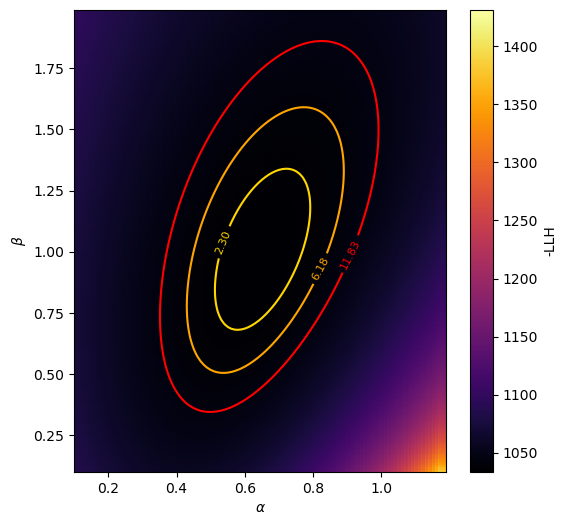

In [111]:
plt.figure(figsize = (6,6))

#raster scan results
sc = plt.scatter(df[r'$\alpha$'],df[r'$\beta$'],c=-llhs,marker = 's', s = 100, cmap = 'inferno')

contours = plt.contour(alphas.reshape(len(alpha_range),len(beta_range)),
           betas.reshape(len(alpha_range),len(beta_range)),
          -(llhs-np.max(llhs)).reshape(len(alpha_range),len(beta_range)),
           [2.3,6.18,11.83],colors=['gold','orange','red'])

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.2f')
cb = plt.colorbar(sc,label=r'-LLH')

#### **Exercise 3**

In [112]:
df_MLE = pd.read_csv('MLE_Variance_data.txt', sep='\s+',header=None)
df_MLE.columns = ['X1','X2']
X1 = df_MLE['X1'].values
X2 = df_MLE['X2'].values

In [113]:
def likelihood(x,alpha,beta):
    #we will transform this into a PDF right away...
    pdf = 1+alpha*x+beta*x**2
    #...remembering the PDF should be normalized! this is the definite integral over range -1..1
    norm = 2+(2*beta/3)
    #return the evaluated PDF only inside -1..1 range, and 0 outside
    return np.where(np.abs(x) <= 1, pdf/norm, 0.)

def norm_pdf(x,alpha,beta):
    #we will transform this into a PDF right away...
    pdf = 1+alpha*x+beta*x**2
    #...remembering the PDF should be normalized! this is the definite integral over range -1..1
    norm = 2+(2*beta/3)
    #return the evaluated PDF only inside -1..1 range, and 0 outside
    return pdf/norm

def likelihood(x,alpha,beta,x_min = -1.,x_max=1.):
    func = lambda x: 1 + alpha*x + beta*x**2
    norm, _ = quad(func, x_min, x_max)
    pdf = 1 + alpha*x + beta*x**2
    normalized_pdf = pdf / norm
    return normalized_pdf

def log_likelihood(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def chi_squared(x_bins, n_obs, alpha, beta):
    # Calculate expected frequencies using the midpoint of each bin
    e_freq = norm_pdf(x_bins, alpha, beta)
    # Normalize expected frequencies to match the total observed counts
    total_obs = np.sum(n_obs)
    e_freq *= total_obs / np.sum(e_freq)
    
    # Calculate chi-squared statistic
    chi2 = np.sum((n_obs - e_freq) ** 2 / e_freq)
    return chi2

In [114]:
lambda_neg_LLH_1 = lambda params: -log_likelihood(X1,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res_1 = minimize(lambda_neg_LLH_1,x0=[0.3,0.3],bounds=((0,1),(0,1)),method='L-BFGS-B')
errors_1 = np.sqrt(np.diag(res_1.hess_inv.todense()))

min_a_1 , min_b_1 = res_1['x']
LLH_1 = res_1.fun

###

lambda_neg_LLH_2 = lambda params: -log_likelihood(X2,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res_2 = minimize(lambda_neg_LLH_2,x0=[0.3,0.3],bounds=((0,1),(0,1)),method='L-BFGS-B')
errors_2 = np.sqrt(np.diag(res_2.hess_inv.todense()))

min_a_2 , min_b_2 = res_2['x']
LLH_2 = res_2.fun

Text(0, 0.5, '$f(x)$')

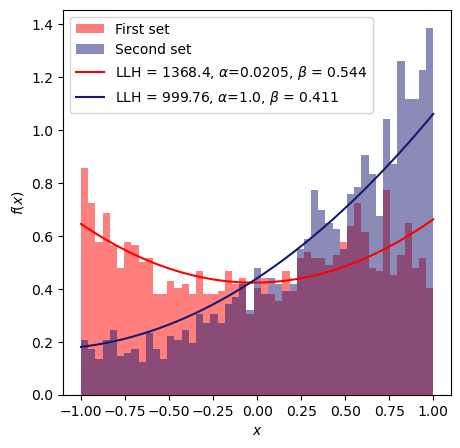

In [115]:
plt.figure(figsize = (5,5))

x_range = np.linspace(-1,1,2000)

plt.hist(X1,bins=np.linspace(-1,1,50),density=True,alpha=0.5,label = 'First set',color='red')
plt.hist(X2,bins=np.linspace(-1,1,50),density=True,alpha=0.5,label = 'Second set',color='midnightblue')
plt.plot(x_range,likelihood(x_range,alpha=min_a_1,beta=min_b_1),
         label=fr'LLH = {LLH_1:.05}, $\alpha$={min_a_1:.03}, $\beta$ = {min_b_1:.03}',linestyle='-',color='red')
plt.plot(x_range,likelihood(x_range,alpha=min_a_2,beta=min_b_2),
         label=fr'LLH = {LLH_2:.05}, $\alpha$={min_a_2:.03}, $\beta$ = {min_b_2:.03}',linestyle='-',color='midnightblue')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [123]:
data = X1
num_bins = 50
bin_edges = np.linspace(-1, 1, num_bins + 1)
counts, _ = np.histogram(data, bins=bin_edges,density=True)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

expected_values = likelihood(bin_midpoints, min_a_1, min_b_1)

# Calculate chi2 (assuming Poisson errors)
sigma = np.sqrt(counts)  # Poisson error
chi2_value = np.sum(((counts - expected_values) ** 2) / sigma ** 2)
degrees_of_freedom = len(counts) - 2  # Adjust '-2' based on your number of parameters
p_value = 1 - chi2.cdf(chi2_value, df=degrees_of_freedom)

# Results
print(f"Chi-squared: {chi2_value}")
print(f"p-value: {p_value}")

Chi-squared: 1.0617941620054263
p-value: 1.0


In [124]:
data = X2
num_bins = 50
bin_edges = np.linspace(-1, 1, num_bins + 1)
counts, _ = np.histogram(data, bins=bin_edges,density=True)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

expected_values = likelihood(bin_midpoints, min_a_2, min_b_2)

# Calculate chi2 (assuming Poisson errors)
sigma = np.sqrt(counts)  # Poisson error
chi2_value = np.sum(((counts - expected_values) ** 2) / sigma ** 2)
degrees_of_freedom = len(counts) - 2  # Adjust '-2' based on your number of parameters
p_value = 1 - chi2.cdf(chi2_value, df=degrees_of_freedom)

# Results
print(f"Chi-squared: {chi2_value}")
print(f"p-value: {p_value}")

Chi-squared: 0.9882119326201346
p-value: 1.0
